# MNIST at Tensorflow

书籍《TensorFlow：实战Googles深度学习框架》第五章 MNIST数字识别问题中5.2.1给出的程序

In [2]:
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets('OriginData/',one_hot=True)
#
print('Training data size:',mnist.train.num_examples)
#
print('Validating data size:',mnist.validation.num_examples)
#
print('Testing data size:',mnist.test.num_examples)
#
print('Example training data:',len(mnist.train.images[0]))
#
print('Example training data labels:',len(mnist.train.labels[0]))

Extracting OriginData/train-images-idx3-ubyte.gz
Extracting OriginData/train-labels-idx1-ubyte.gz
Extracting OriginData/t10k-images-idx3-ubyte.gz
Extracting OriginData/t10k-labels-idx1-ubyte.gz
Training data size: 55000
Validating data size: 5000
Testing data size: 10000
Example training data: 784
Example training data labels: 10


In [3]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

# MNIST数据集相关的常数
INPUT_NODE = 784
OUTPUT_NODE = 10

# 配置神经网络的参数
LAYER1_NODE = 500       # 隐藏层节点数。这里使用只有一个隐藏层的网络结构
BATCH_SIZE = 100        # 一个训练batch中的训练数据个数
LEARNING_RATE_BASE = 0.8 # 基础学习率
LEARNING_RATE_DECAY = 0.99 # 学习理财的衰减率
REGULARIZATION_RATE = 0.0001 # 描述模型复杂度的正则化项在损失函数中农的系数
TRAINING_STEPS = 5000
MOVING_AVERAGE_DECAY = 0.99

# 很多说明
def inference(input_tensor, avg_class, weights1, biases1,
              weights2, biases2):
    # 当没有提供滑动平均类时，直接使用参数的当前取值
    if avg_class == None:
        layer1 = tf.nn.relu(tf.matmul(input_tensor, weights1) + biases1)
        return tf.matmul(layer1, weights2) + biases2
    else:
        layer1 = tf.nn.relu(tf.matmul(input_tensor, avg_class.average(weights1))+
                           avg_class.average(biases1))
        return tf.matmul(layer1, avg_class.average(weights2)) + \
               avg_class.average(biases2)
        
# 训练模型的过程
def train(mnist):
    x = tf.placeholder(tf.float32, [None, INPUT_NODE], name='x-input' )
    y_ = tf.placeholder(tf.float32, [None, OUTPUT_NODE], name='y-input')
    
    # 生成隐藏层的参数
    weights1 = tf.Variable(tf.truncated_normal([INPUT_NODE, LAYER1_NODE], stddev=0.1))
    biases1 = tf.Variable(tf.constant(0.1, shape=[LAYER1_NODE]))
    # 生成输出层的参数
    weights2 = tf.Variable(tf.truncated_normal([LAYER1_NODE, OUTPUT_NODE], stddev=0.1))
    biases2 = tf.Variable(tf.constant(0.1, shape=[OUTPUT_NODE]))
    # 计算在当前参数下神经网络前向传播的结果。这里给出的用于计算
    # 滑动平均的类为None，所以函数不会使用参数的滑动平均值
    y = inference(x, None, weights1, biases1, weights2, biases2)
    # 定义存储训练论述的变量
    global_step = tf.Variable(0,trainable=False)
    
    # 给定滑动平均衰减率和训练轮数的变量，初始化滑动平均类。
    variable_averages = tf.train.ExponentialMovingAverage(
                        MOVING_AVERAGE_DECAY, global_step)
    #
    variables_averages_op = variable_averages.apply(tf.trainable_variables())
    # 计算使用了滑动平均之后的前向传播结果
    average_y = inference(x, variable_averages, weights1, biases1, weights2, biases2)
    # 计算交叉熵作为刻画预测值和真实值之间产局的损失函数。
    cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=tf.argmax(y_,1), logits=y)
    # 计算在当前batch中所有样例的交叉熵平均值
    cross_entropy_mean = tf.reduce_mean(cross_entropy)
    
    # 计算L2正则化损失函数
    regularizer = tf.contrib.layers.l2_regularizer(REGULARIZATION_RATE)
    # 计算模型的正则损失。
    regularization = regularizer(weights1) + regularizer(weights2)
    # 总损失等于交叉熵损失和正则化损失的和
    loss = cross_entropy_mean + regularization
    # 设置指数衰减的学习率
    learning_rate = tf.train.exponential_decay(
                    LEARNING_RATE_BASE,
                    global_step,
                    mnist.train.num_examples / BATCH_SIZE,
                    LEARNING_RATE_DECAY)
    # 使用tf.train.GradientDescentOptimizer优化算法来优化损失函数，
    # 这里的损失函数包含了交叉熵损失和L2正则损失。
    train_step = tf.train.GradientDescentOptimizer(learning_rate)\
                   .minimize(loss, global_step=global_step)
    # 
    with tf.control_dependencies([train_step, variables_averages_op]):
        train_op = tf.no_op(name='train')
    #
    correct_prediction = tf.equal(tf.argmax(y,1),tf.argmax(y_,1))
    # 
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    # 初始化会话并开始训练过程
    with tf.Session() as sess:
        tf.global_variables_initializer().run()
        # 准备验证数据。
        # 条件和评判训练的效果
        validate_feed = {x: mnist.validation.images,
                         y_: mnist.validation.labels}
        # 准备测试数据。在真实的应用中，这部分数据在训练时时不可见的，这个数据只是
        # 作为模型优劣的最后评价标准。
        test_feed = {x:mnist.test.images, y_:mnist.test.labels}
    
        # 迭代地训练神经网络
        for i in range(TRAINING_STEPS):
            # 每1000轮输出一次在验证数据集上的测试结果
            if i % 1000 ==0:
            #
                validate_acc = sess.run(accuracy, feed_dict=validate_feed)
                print("After %d training step(s),validation accuracy"
                      "using average model is %g" % (i, validate_acc))
            # 产生这一轮使用的一个batch的训练数据，并运行训练过程
            xs, ys = mnist.train.next_batch(BATCH_SIZE)
            sess.run(train_op, feed_dict={x:xs, y_:ys})
    
        # 在训练结束之后，在测试数据上检测神经网络模型的最终正确率
        test_acc = sess.run(accuracy, feed_dict=test_feed)
        print("After %d training step(s), test accuracy using average "
              "model is %g" % (TRAINING_STEPS, test_acc))
    
# 主程序入口
def main(argv=None):
    # 声明处理MNIST数据集的类，这个类在初始化时会自动下载数据。
    mnist = input_data.read_data_sets('OriginData/',one_hot=True)
    train(mnist)
    
# TensorFlow 提供一个主程序入口， tf.app.run会调用上面定义的main函数
if __name__ == '__main__':
    tf.app.run()

Extracting OriginData/train-images-idx3-ubyte.gz
Extracting OriginData/train-labels-idx1-ubyte.gz
Extracting OriginData/t10k-images-idx3-ubyte.gz
Extracting OriginData/t10k-labels-idx1-ubyte.gz
After 0 training step(s),validation accuracyusing average model is 0.1138
After 1000 training step(s),validation accuracyusing average model is 0.9726
After 2000 training step(s),validation accuracyusing average model is 0.977
After 3000 training step(s),validation accuracyusing average model is 0.9826
After 4000 training step(s),validation accuracyusing average model is 0.9832
After 5000 training step(s), test accuracy using average model is 0.9813


SystemExit: 

/Users/ean2/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2889: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [21]:
import numpy as np
np.shape(mnist.train.labels)

(55000, 10)

# 第七章 图像数据处理


## 图像数据处理

### 7.2.1 TensorFlow图像处理函数

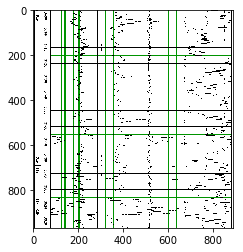

In [8]:
import matplotlib.pyplot as plt
import tensorflow as tf

# 读取图像原始数据
image_raw_data = tf.gfile.FastGFile(r'C:\Users\Ean2\Pictures\Saved Pictures\111.png','rb').read()

with tf.Session() as sess:
    img_data = tf.image.decode_png(image_raw_data)
    #print('img_data.eval():\n',img_data.eval())
    # 使用pyplot 工具可视化得到图像
    plt.imshow(img_data.eval())
    plt.show()
    
    # 将数据转换成实数方便处理
    img_data = tf.image.convert_image_dtype(img_data, dtype=tf.uint16)
    #print(img_data.eval())
    encoded_image = tf.image.encode_png(img_data)
    with tf.gfile.GFile(r'C:\Users\Ean2\Pictures\Saved Pictures\222.png','wb') as f:
        f.write(encoded_image.eval())

## 7.3 多线程输入数据处理

### 7.3.1 队列与多线程

修改队列状态的操作主要有：Enqueue\EnqueueMany\Dequeue

In [7]:
import tensorflow as tf

q = tf.FIFOQueue(2,'int32')       # 创建一个先进先出队列
init = q.enqueue_many(([0,10],)) # 使用enqueue_many来初始化队列
x = q.dequeue()                # 使用dequeue函数将队列中第一个元素出队列
y = x + 1
q_inc = q.enqueue([y])         # 将y重新加入队列

with tf.Session() as sess:
    init.run()                 # 初始化队列
    for _ in range(5):
        v, _  = sess.run([x,q_inc])
        print(v)               # 打印出队列的元素

0
10
1
11
2


TensorFlow提供了tf.Coordinator和tf.QueueRunner两个类来完成多线程协同功能

tf.Coordinator主要用于协同多个线程一起停止，提供了should_stop request_stop join三个函数。

In [14]:
import tensorflow as tf
import numpy as np
import threading
import time

def MyLoop(coord, worker_id):
    while not coord.should_stop():
        if np.random.rand() < 0.1:
            print("Stoping from id: %d\n" % worker_id)
            coord.request_stop()
        else:
            print("Working on id: %d\n" % worker_id)
        time.sleep(1)

coord = tf.train.Coordinator()
threads = [threading.Thread(target=MyLoop, args=(coord,i,))
          for i in range(5)]
for t in threads: t.start()

coord.join(threads)


Working on id: 0

Working on id: 1

Working on id: 2

Working on id: 3

Working on id: 4

Working on id: 0

Working on id: 2
Stoping from id: 1
Working on id: 3





tf.QueueRunner主要用于启动多个线程来操作同一个队列。

In [16]:
import tensorflow as tf

queue = tf.FIFOQueue(100,"float")

enqueue_op = queue.enqueue([tf.random_normal([1])])

qr = tf.train.QueueRunner(queue, [enqueue_op]*5)

tf.train.add_queue_runner(qr)
out_tensor = queue.dequeue()

with tf.Session() as sess:
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(sess=sess,coord=coord)
    for _ in range(3): print(sess.run(out_tensor)[0])

    coord.request_stop()
    coord.join(threads)

-2.71738
1.50666
-2.30256


# 第10章

## 10.1 TensorFlow使用GPU

TensorFlow提供了一个快捷的方式来查看运行于每个运算的设备。下面展示如何使用log_device_placement这个参数。

In [15]:
import tensorflow as tf

a = tf.constant([1.0,2.0,3.0], shape=[3], name='a')
b = tf.constant([1.0,2.0,3.0], shape=[3], name='b')
c = a + b

sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
print(sess.run(c))

[ 2.  4.  6.]
